In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/02_outlet.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [3]:
config['domain']

{'adjustParticle': False, 'adjustDomain': False, 'dim': 2, 'periodic': True}

In [4]:
nx = 128
L = 1
u_mag = 5
k = 1 * np.pi
TGV_override = False
targetRe = 1000

config['domain']['minExtent'] = [-2.2,-1.2]
config['domain']['maxExtent'] =  [2.2,1.2]
config['domain']['periodic'] = False

config['boundary']['active'] = True

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda', 'checkNaN': True}
# config['compute'] = {'device': 'cpu'}


config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)
config['diffusion']['alpha'] = 0.01
config['diffusion']['pi-switch']=False
config['gravity']['active'] = True
config['EOS']['type'] = 'stiffTait'

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


Re = 1000.0, $\nu_{sph} = 0.009999999776482582$, $\alpha = 0.01$


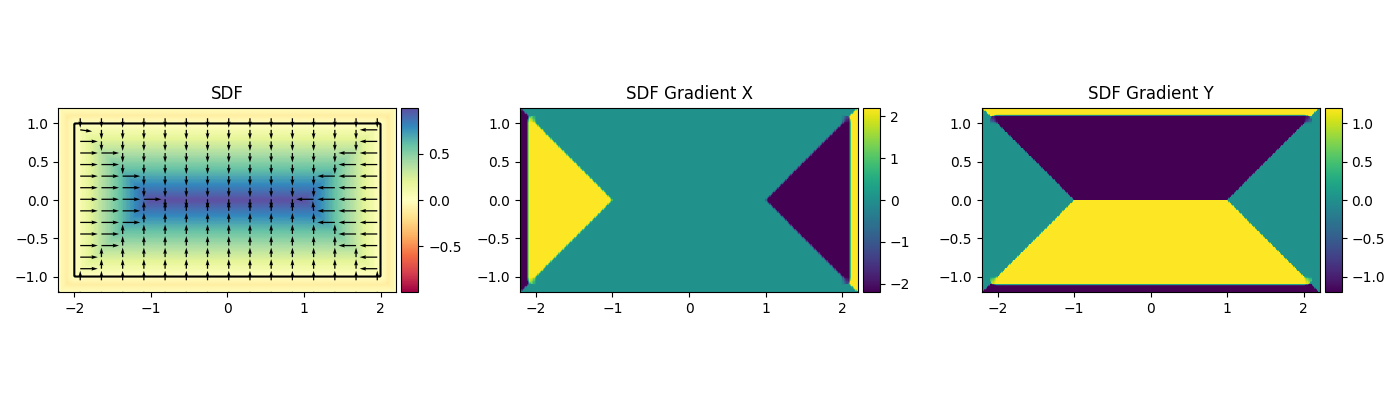

In [5]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('polygon')['function'](points, torch.tensor([[0.5,0.5],[0.5,-0.5],[-0.5,-0.5],[-0.5,0.5]]))
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
inner = lambda points: getSDF('box')['function'](points, torch.tensor([2,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([2 + config['particle']['support'] * 3,1 + config['particle']['support'] * 3]).to(points.device))


translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)

outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
sdf = operatorDict['invert'](sdf)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sdf
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [6]:
from torch.profiler import profile, record_function, ProfilerActivity
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour

In [7]:


ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([2,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([2 + config['particle']['support'] * 2,1 + config['particle']['support'] * 2]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](sdf)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/2,1/2]).to(points.device))
fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
    # {
    #     'sdf': inletSDF,
    #     'type': 'inlet',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    # {
    #     'sdf': inletSDF,
    #     'type': 'forcing',
    #     'forcingMode': 'immediate',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletSDF,
    #     'type': 'outlet',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletSDF])[0],
    #     'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletRegion,
    #     'type': 'mirror',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletRegion])[0],
    #     'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    {
        'sdf': boundary_sdf,
        'type': 'boundary',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [boundary_sdf])[0],
        'contour': find_contour(boundary_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

config['regions'] = regions

# fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
# setPlotBaseAttributes(axis[0,0], config)
# # setPlotBaseAttributes(axis[0,1], config)

# # plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,0])


In [8]:
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs
from diffSPH.v2.finiteDifference import centralDifferenceStencil, continuousGradient

particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'fluid'])
boundaryState = processBoundarySDFs(particleState, config, [region['sdf'] for region in regions if region['type'] == 'boundary'], 'regular')


config['timestep']['dt'] = 1e-3
s = 2
perennialState = {
    'fluid': copy.deepcopy(particleState),
    'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
    'uidCounter': particleState['numParticles']
}

u = 1

perennialState['fluid']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['fluid']['numParticles'], 2], device = perennialState['fluid']['positions'].device)
perennialState['boundary']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['boundary']['numParticles'], 2], device = perennialState['boundary']['positions'].device)


p = perennialState['boundary']['positions']
# inner()
sdf = inner
h = config['particle']['support']

stencil = centralDifferenceStencil(1, 2)
stencil = stencil.to(p.device)
sdfValues = sdf(p.cpu()).to(p.device)

sdfGradient = continuousGradient(sdf, p, stencil, 0.2 * h, 1)
perennialState['boundary']['normals'] = -sdfGradient / (torch.linalg.norm(sdfGradient, dim = 1, keepdim = True) + 1e-6)
perennialState['boundary']['distances'] = sdfValues

In [9]:
from diffSPH.v2.plotting import visualizeParticleQuantity

Text(0.5, 0.98, 'Time: 0.00 s, timestep: 0, dt: 1.00e-03 s, particles: 8169 (2809 fluid + 5360 boundary)')

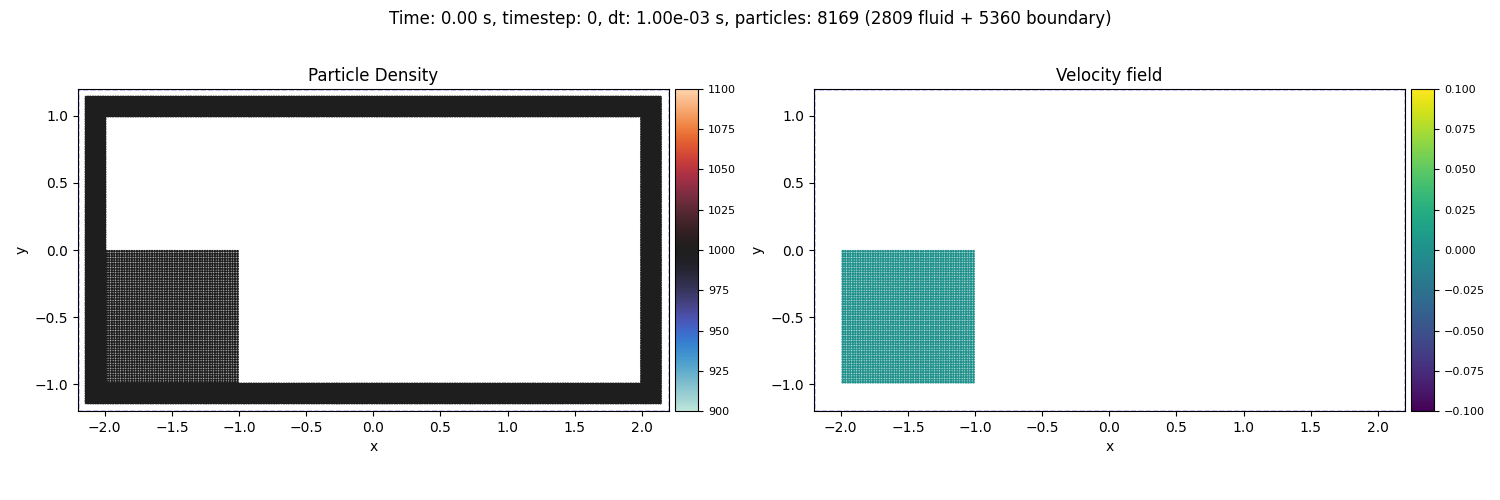

In [10]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
s = 1

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'densities', mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Particle Density', which = 'both', plotBoth = True, midPoint = 1000)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field', plotBoth = False, which = 'fluid', midPoint = 1000)


# axis[0,0].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu().numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)
# axis[0,1].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu() .numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)

fig.tight_layout()

fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')

In [11]:
from diffSPH.v2.plotting import exportPlot, postProcessPlot
from diffSPH.v2.simulationSchemes.deltaPlus import checkNaN

priorState = None
for i in tqdm(range(3300)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['shiftAmount'] = dx
    perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    if config['compute']['checkNaN']:
        checkNaN(perennialState['fluid']['positions'], 'positions')
        checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    
    # perennialState = simulationStep(perennialState, config)
    # perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
    # perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    if i % 30 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'densities')
        updatePlot(quantPlot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)

    for emitter in config['regions']:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)
        if emitter['type'] == 'forcing':
            processForcing(emitter, config, perennialState)


  0%|          | 0/3300 [00:00<?, ?it/s]

In [ ]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

In [19]:
state = copy.deepcopy(perennialState)
prevState = copy.deepcopy(priorState)

integrate(simulationStep, state, config, previousStep= prevState)

({'fluid': {'numParticles': 2809,
   'positions': tensor([[-1.9693, -0.9859],
           [-1.9322, -0.9851],
           [-1.9133, -0.9875],
           ...,
           [ 1.0311, -0.7530],
           [ 1.3265, -0.5011],
           [-0.9193, -0.8098]], device='cuda:0'),
   'areas': tensor([0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004], device='cuda:0'),
   'pressures': tensor([-137.2184,  341.9604,  764.5147,  ...,  790.8259, 1958.1403,
           -389.6228], device='cuda:0'),
   'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
   'masses': tensor([0.3516, 0.3516, 0.3516,  ..., 0.3516, 0.3516, 0.3516], device='cuda:0'),
   'supports': tensor([0.0712, 0.0712, 0.0712,  ..., 0.0712, 0.0712, 0.0712], device='cuda:0'),
   'index': tensor([   0,    1,    2,  ..., 2806, 2807, 2808], device='cuda:0'),
   'densities': tensor([ 999.9365, 1000.1326, 1000.3017,  ..., 1000.3157, 1000.7740,
            999.8447], device='cuda:0'),
   'velocities': tensor([[ 2.4729e-03,  2.

In [14]:

@torch.jit.script
def pinv2x2(M):
    with record_function('Pseudo Inverse 2x2'):
        a = M[:,0,0]
        b = M[:,0,1]
        c = M[:,1,0]
        d = M[:,1,1]

        theta = 0.5 * torch.atan2(2 * a * c + 2 * b * d, a**2 + b**2 - c**2 - d**2)
        cosTheta = torch.cos(theta)
        sinTheta = torch.sin(theta)
        U = torch.zeros_like(M)
        U[:,0,0] = cosTheta
        U[:,0,1] = - sinTheta
        U[:,1,0] = sinTheta
        U[:,1,1] = cosTheta

        S1 = a**2 + b**2 + c**2 + d**2
        S2 = torch.sqrt((a**2 + b**2 - c**2 - d**2)**2 + 4* (a * c + b *d)**2)

        o1 = torch.sqrt((S1 + S2) / 2)
        if torch.any(torch.isnan(o1)):
            print('NAN in o1')
            nan_indices = torch.arange(o1.shape[0], device = o1.device)[torch.isnan(o1)]
            for i in nan_indices:
                print(f'M[{i}]: {M[i]}')
                print(f'S1: {S1[i]}')
                print(f'S2: {S2[i]}')
                print(f'o1 = sqrt({S1[i] + S2[i]}) / 2 = {o1[i]}')

        o2 = torch.sqrt((S1 - S2 + 1e-7) / 2)
        if torch.any(torch.isnan(o2)):
            print('NAN in o2')
            nan_indices = torch.arange(o2.shape[0], device = o2.device)[torch.isnan(o2)]
            for i in nan_indices:
                print(f'M[{i}]: {M[i]}')
                print(f'S1: {S1[i]}')
                print(f'S2: {S2[i]}')
                print(f'o2 = sqrt({S1[i] - S2[i]}) / 2 = {o2[i]}')

        phi = 0.5 * torch.atan2(2 * a * b + 2 * c * d, a**2 - b**2 + c**2 - d**2)
        cosPhi = torch.cos(phi)
        sinPhi = torch.sin(phi)
        s11 = torch.sign((a * cosTheta + c * sinTheta) * cosPhi + ( b * cosTheta + d * sinTheta) * sinPhi)
        s22 = torch.sign((a * sinTheta - c * cosTheta) * sinPhi + (-b * sinTheta + d * cosTheta) * cosPhi)

        V = torch.zeros_like(M)
        V[:,0,0] = cosPhi * s11
        V[:,0,1] = - sinPhi * s22
        V[:,1,0] = sinPhi * s11
        V[:,1,1] = cosPhi * s22


        o1_1 = torch.zeros_like(o1)
        o2_1 = torch.zeros_like(o2)

        o1_1[torch.abs(o1) > 1e-5] = 1 / o1[torch.abs(o1) > 1e-5] 
        o2_1[torch.abs(o2) > 1e-5] = 1 / o2[torch.abs(o2) > 1e-5] 
        o = torch.vstack((o1_1, o2_1))
        S_1 = torch.diag_embed(o.mT, dim1 = 2, dim2 = 1)

        if torch.any(torch.isnan(S_1)):
            print('NAN in S_1')


        eigVals = torch.vstack((o1, o2)).mT
        eigVals[torch.abs(eigVals[:,1]) > torch.abs(eigVals[:,0]),:] = torch.flip(eigVals[torch.abs(eigVals[:,1]) > torch.abs(eigVals[:,0]),:],[1])

        if torch.any(torch.isnan(eigVals)):
            print('NAN in eigVals')

        return torch.matmul(torch.matmul(V, S_1), U.mT), eigVals

In [15]:
def computeNormalizationMatrices(stateA, stateB, neighborhood, simConfig):
    with record_function("[SPH] - Normalization Matrices (nabla x)"):
        with record_function("[SPH] - Normalization Matrices (Matrix Computation)"):
            distances = -(neighborhood['distances'] * neighborhood['supports']).view(-1,1) * neighborhood['vectors']
            normalizationMatrices = sphOperationStates(stateA, stateB, distances, operation = 'gradient', gradientMode = 'difference', neighborhood = neighborhood)
            checkNaN(normalizationMatrices, 'normalizationMatrices')
  
        with record_function("[SPH] - Normalization Matrices (Pseudo-Inverse)"):
            L, lambdas = pinv2x2(normalizationMatrices)
            checkNaN(L, 'L')
            checkNaN(lambdas, 'lambdas')

        return L, normalizationMatrices, lambdas

In [133]:

# from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceBarecasco, computeNormalsMaronne, detectFreeSurfaceMaronne, expandFreeSurfaceMask, computeColorField, computeColorFieldGradient, detectFreeSurfaceColorFieldGradient
from diffSPH.v2.modules.shifting import computeLambdaGrad, deltaPlusShifting, computeShifting, BiCGStab_wJacobi, BiCG, LinearCG, BiCGStab

def solveShifting(simulationState, config):
    with record_function("[Shifting] - Compute Shift Amount"):
        numParticles = simulationState['fluid']['numParticles']
        fluidState = simulationState['fluid']
        boundaryParticleState = simulationState['boundary'] if 'boundary' in simulationState else None

        mergedPositions = torch.cat((fluidState['positions'], boundaryParticleState['positions']), dim = 0) if boundaryParticleState is not None else fluidState['positions']
        mergedVelocities = torch.cat((fluidState['velocities'], boundaryParticleState['velocities']), dim = 0) if boundaryParticleState is not None else fluidState['velocities']
        mergedMasses = torch.cat((fluidState['masses'], boundaryParticleState['masses']), dim = 0) if boundaryParticleState is not None else fluidState['masses']
        mergedAreas = torch.cat((fluidState['areas'], boundaryParticleState['areas']), dim = 0) if boundaryParticleState is not None else fluidState['areas']
        mergedDensities = torch.cat((fluidState['densities'], boundaryParticleState['densities']), dim = 0) if boundaryParticleState is not None else fluidState['densities']
        mergedSupports = torch.cat((fluidState['supports'], boundaryParticleState['supports']), dim = 0) if boundaryParticleState is not None else fluidState['supports']
        boundaryMarker = torch.cat((torch.zeros(fluidState['positions'].shape[0], dtype = torch.int32), torch.ones(boundaryParticleState['positions'].shape[0], dtype = torch.int32))) if boundaryParticleState is not None else torch.zeros(fluidState['positions'].shape[0], dtype = torch.int32)
        
        particleState = {
            'positions': mergedPositions,
            'velocities': mergedVelocities,
            'masses': mergedMasses,
            'densities': mergedDensities,
            'supports': mergedSupports,
            'areas': mergedAreas,
            'numParticles': mergedPositions.shape[0],
            'boundaryMarker': boundaryMarker
        }
        if 'neighborhood' in simulationState['fluid']:
            particleState['neighborhood'] = simulationState['fluid']['neighborhood']

        for k in particleState:
            if isinstance(k, torch.Tensor):
                checkNaN(particleState[k], k)

        initialPositions = torch.clone(particleState['positions'])
        initialDensities = torch.clone(particleState['densities'])
        overallStates = []
        for i in range(config['shifting']['maxIterations']):
            with record_function("[Shifting] - Shift Iteration [Iteration: %3d]" % i):
                with record_function("[Shifting] - Shift Iteration [1 - Neighbor Search]"):
                    particleState['datastructure'], particleState['neighborhood'] = neighborSearch(particleState, particleState, config, 
                        computeKernels = True, 
                        priorState = None if 'neighborhood' not in particleState else particleState['neighborhood'],
                        neighborDatastructure = None if 'datastructure' not in particleState else particleState['datastructure'],
                        verbose = False)
                    particleState['numNeighbors'] = particleState['neighborhood']['numNeighbors']
                
                    
                    # particleState['neighborhood'] = neighborSearch(particleState, particleState, config, priorNeighborhood=particleState['neighborhood'] if 'neighborhood' in particleState else None)
                if config['shifting']['summationDensity']:
                    particleState['densities'] = sphOperationStates(particleState, particleState, None, operation = 'density', neighborhood=particleState['neighborhood'])

                with record_function("[Shifting] - Shift Iteration [2 - Surface Detection]"):
                    if config['shifting']['freeSurface']:
                        if config['shifting']['surfaceDetection'] == 'Maronne':
                            particleState['L'], normalizationMatrices, particleState['L.EVs'] = computeNormalizationMatrices(particleState, particleState, particleState['neighborhood'], config)
                            checkNaN(particleState['L'], 'L')
                            checkNaN(particleState['L.EVs'], 'L.EVs')
                            particleState['normals'], particleState['Lambdas'] = computeNormalsMaronne(particleState, particleState, particleState['neighborhood'], config)
                            checkNaN(particleState['normals'], 'normals')
                            checkNaN(particleState['Lambdas'], 'Lambdas')
                            particleState['freeSurface'], cA, cB = detectFreeSurfaceMaronne(particleState, particleState, particleState['neighborhood'], config)
                        elif config['shifting']['surfaceDetection'] == 'colorGrad':
                            particleState['color'] = computeColorField(particleState, particleState, particleState['neighborhood'], config)
                            particleState['colorGradient'] = computeColorFieldGradient(particleState, particleState, particleState['neighborhood'], config)
                            checkNaN(particleState['color'], 'color')
                            checkNaN(particleState['colorGradient'], 'colorGradient')
                            particleState['freeSurface'] = detectFreeSurfaceColorFieldGradient(particleState, particleState, particleState['neighborhood'], config)

                        elif config['shifting']['surfaceDetection'] == 'Barcasco':
                            particleState['freeSurface'] = detectFreeSurfaceBarecasco(particleState, particleState, particleState['neighborhood'], config)
                                        
                        particleState['freeSurfaceMask'] = expandFreeSurfaceMask(particleState, particleState, particleState['neighborhood'], config)
                        checkNaN(particleState['freeSurface'], 'freeSurface')
                        checkNaN(particleState['freeSurfaceMask'], 'freeSurfaceMask')

                
                with record_function("[Shifting] - Shift Iteration [3 - Shift Computation]"):
                    if config['shifting']['scheme'] == 'IPS':
                        update, K, J, H, B, convergence, iters, residual = computeShifting(particleState, config, computeRho = config['shifting']['summationDensity'], scheme = config['shifting']['solver'])
                        overallStates.append((convergence, iters, residual))
                    else:
                        update = -deltaPlusShifting(particleState, config)
                        checkNaN(update, 'update')
                        # print(f'Update: {update.max()}, {update.min()}')
                with record_function("[Shifting] - Shift Iteration [4 - Surface Projection]"):
                    if config['shifting']['freeSurface']:
                        if config['shifting']['normalScheme'] == 'color':
                            ones = torch.ones_like(particleState['supports'])
                            colorField = sphOperationStates(particleState, particleState, neighborhood = particleState['neighborhood'], quantities = (ones, ones), operation = 'interpolate')
                            checkNaN(colorField, 'colorField')
                            gradColorField = sphOperationStates(particleState, particleState, neighborhood = particleState['neighborhood'], quantities = (colorField, colorField), operation = 'gradient', gradientMode = 'difference')
                            checkNaN(gradColorField, 'gradColorField')
                            n = torch.nn.functional.normalize(gradColorField, dim = -1)
                            checkNaN(n, 'normals')
                            particleState['normals'] = n
                        elif config['shifting']['normalScheme'] == 'lambda':
                            # if 'fluidL' not in particleState:                        
                            particleState['L'], normalizationMatrices, particleState['L.EVs'] = computeNormalizationMatrices(particleState,particleState,particleState['neighborhood'], config)
                            checkNaN(particleState['L'], 'L')
                            checkNaN(particleState['L.EVs'], 'L.EVs')
                            particleState['normals'], particleState['Lambdas'] = computeNormalsMaronne(particleState, particleState,particleState['neighborhood'], config)
                            checkNaN(particleState['normals'], 'normals')
                            n = torch.nn.functional.normalize(computeLambdaGrad(particleState, config), dim = -1)
                            particleState['normals'] = n
                        else:
                            n = particleState['normals']
                        checkNaN(n, 'normals')

                        fs = particleState['freeSurface']
                        fsm = particleState['freeSurfaceMask']
                        checkNaN(fs, 'freeSurface')
                        checkNaN(fsm, 'freeSurfaceMask')
                        checkNaN(update, 'update')
                        # print(update[fs > 0.5].abs().max())
                        if config['shifting']['projectionScheme'] == 'dot':
                            result = update + torch.einsum('ij,ij->i', update, n)[:, None] * n
                            checkNaN(result, 'result')
                            update[fsm > 0.5] = result[fsm > 0.5] * config['shifting']['surfaceScaling']
                            checkNaN(update, 'update after projection')
                            # update[fs > 0.5] = 0
                            update[particleState['Lambdas'] < 0.4] = 0
                            checkNaN(update, 'update after clamp')
                        elif config['shifting']['projectionScheme'] == 'mat':
                            nMat = torch.einsum('ij, ik -> ikj', particleState['normals'], particleState['normals'])
                            checkNaN(nMat, 'nMat')
                            M = torch.diag_embed(particleState['positions'].new_ones(particleState['positions'].shape)) - nMat
                            checkNaN(M, 'M')
                            result = torch.bmm(M, update.unsqueeze(-1)).squeeze(-1)
                            checkNaN(result, 'result')
                            update[fsm > 0.5] = result[fsm > 0.5] 
                            checkNaN(update, 'update after projection')
                            update[particleState['Lambdas'] < 0.4] = 0
                            checkNaN(update, 'update after clamp')
                            update[fs > 0.5] = update[fs > 0.5] * config['shifting']['surfaceScaling']
                            checkNaN(update, 'update after scaling')
                        else:
                            update[particleState['Lambdas'] < 0.4] = 0
                            # update[fs > 0.5] = 0
                        
                with record_function("[Shifting] - Shift Iteration [5 - Update]"):
                    spacing = config['particle']['dx']
                    # print(
                    #     f'Iter: {i}, Threshold {config["shifting"]["threshold"] * spacing}, max Update = {update.max()} Ratio {update.max() / (config["shifting"]["threshold"] * spacing)}')

                    update = torch.clamp(update, -config['shifting']['threshold'] * spacing, config['shifting']['threshold'] * spacing)
                    update[boundaryMarker != 0,:] = 0
                    # print(f'Update: {update.max()} Ratio: {update.max() / (config["shifting"]["threshold"] * spacing)}')
                    # update = torch.clamp(update, -config['shifting']['threshold'] * spacing, config['shifting']['threshold'] * spacing)
                    particleState['positions'] = particleState['positions'] - update

                # print(f'J: {J.abs().max()}')
        dx = particleState['positions'] - initialPositions
        particleState['positions'] = initialPositions
        particleState['densities'] = initialDensities

        simulationState['fluid']['positions'] = particleState['positions'][:numParticles]
        simulationState['fluid']['densities'] = particleState['densities'][:numParticles]
        dx = dx[:numParticles]

        if 'neighborhood' in simulationState['fluid']:
            if 'boundary' not in simulationState:
                simulationState['fluid']['neighborhood'] = particleState['neighborhood']

        return dx, overallStates

In [134]:
config['shifting']['projectionScheme']

'mat'

In [135]:
dx, _ = solveShifting(state, config)
state['fluid']['shiftAmount'] = dx
checkNaN(state['fluid']['positions'], 'positions')
checkNaN(state['fluid']['shiftAmount'], 'shiftAmount')


In [41]:


with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
    searchNeighbors(state, config)
    # torch.cuda.synchronize()

with record_function("[SPH] - deltaSPH (2 - Ghost Particle Creation)"):
    state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
    state['outletGhost'] = buildOutletGhostParticles(regions, state, config)
    # torch.cuda.synchronize()
    
with record_function("[SPH] - deltaSPH (3 - Density Computation)"):
    if config['simulation']['densityScheme'] == 'summation':
        if config['boundary']['active']:
            state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
        else:
            state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')
        torch.cuda.synchronize()
    if config['boundary']['active']:
        with record_function("[SPH] - deltaSPH (3 - mDBC Density Estimate)"):
            state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)
            # state['boundary']['densities'] += torch.abs(state['boundary']['distances']) / config['particle']['support'] * 2
            # torch.cuda.synchronize()
    checkNaN(state['fluid']['densities'], 'densities')
    if config['boundary']['active']:
        checkNaN(state['boundary']['densities'], 'boundary - densities')

if state['outletGhost'] is not None:
    with record_function("[SPH] - deltaSPH (4 - Outlet Processing)"):
        ghostState = state['outletGhost']
        neighbors = ghostState['neighborhood']['indices'][0]
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['densities'])

        cond = torch.logical_and(ghostState['numNeighbors'] >= 10, ghostState['sdf_dist'] < 2.5 * config['particle']['support'])
        cond = ghostState['numNeighbors'] >= 10

        def updateQuantity(state, ghostState, quantity, solution, cond):
            return torch.where(cond, solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:]), quantity)
        state['fluid']['densities'][ghostState['fluidIndex']] = updateQuantity(state, ghostState, state['fluid']['densities'][ghostState['fluidIndex']], solution, cond)
        
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,0])
        state['fluid']['velocities'][ghostState['fluidIndex'],0] = updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,0], solution, cond)

        
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,1])
        state['fluid']['velocities'][ghostState['fluidIndex'],1] =updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,1], solution, cond)
        
        checkNaN(state['fluid']['densities'], 'densities')
        checkNaN(state['fluid']['velocities'], 'velocities')
        

        # torch.cuda.synchronize()

with record_function("[SPH] - deltaSPH (5 - Normalization Matrices)"):
    # state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
    state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluid')
    state['fluid']['covarianceMatrix'][state['fluid']['numNeighbors'] < 4,:,:] = torch.eye(2, dtype = state['fluid']['covarianceMatrix'].dtype, device = state['fluid']['covarianceMatrix'].device)[None,:,:]
    checkNaN(state['fluid']['covarianceMatrix'], 'covarianceMatrix')

    state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])

    checkNaN(state['fluid']['L'], 'L')
    checkNaN(state['fluid']['L.EVs'], 'L.EVs')

    # torch.cuda.synchronize()

with record_function("[SPH] - deltaSPH (6 - Density Gradient)"):
    state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')
    checkNaN(state['fluid']['gradRho^L'], 'gradRho^L')

    # if config['boundary']['active']:
        # state['fluid']['gradRho^L'] += callModule(state, densityGradient, config, 'boundaryToFluid')[0]


    # state['boundary']['gradRho^L'] = callModule(state, densityGradient, config, 'boundary')[1]
    # torch.cuda.synchronize()

with record_function("[SPH] - deltaSPH (7 - Diffusion and Momentum)"):
    state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid')
    checkNaN(state['fluid']['densityDiffusion'], 'densityDiffusion')
    # state['fluid']['densityDiffusion'] += callModule(state, computeDensityDeltaTerm, config, 'boundaryToFluid')[0]

    # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
    # torch.cuda.synchronize()
    if config['boundary']['active']:
        # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
        state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'all')
        checkNaN(state['fluid']['velocityDiffusion'], 'velocityDiffusion')
        checkNaN(state['boundary']['velocityDiffusion'], 'boundary - velocityDiffusion')

        state['fluid']['momentumEquation'], state['boundary']['momentumEquation'] = callModule(state, computeMomentumEquation, config, 'all')
        checkNaN(state['fluid']['momentumEquation'], 'momentumEquation')
        checkNaN(state['boundary']['momentumEquation'], 'boundary - momentumEquation')
    else:
        state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
        checkNaN(state['fluid']['velocityDiffusion'], 'velocityDiffusion')

        state['fluid']['momentumEquation'], _ = callModule(state, computeMomentumEquation, config, 'fluid')
        checkNaN(state['fluid']['momentumEquation'], 'momentumEquation')
    # torch.cuda.synchronize()
    state['fluid']['pressures'] = computeEOS(state['fluid'], config)
    checkNaN(state['fluid']['pressures'], 'pressures')

    if 'boundary' in state:
        state['boundary']['pressures'] = computeEOS(state['boundary'], config)
        checkNaN(state['boundary']['pressures'], 'boundary - pressures')

with record_function("[SPH] - deltaSPH (8 - Pressure Forces)"):
    if 'boundary' in state:
        state['fluid']['pressureAccel'], state['boundary']['pressureAccel'] = callModule(state, computePressureAccel, config, 'all')
        checkNaN(state['fluid']['pressureAccel'], 'pressureAccel')
        checkNaN(state['boundary']['pressureAccel'], 'boundary - pressureAccel')
    else:
        state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccel, config, 'fluid')
        checkNaN(state['fluid']['pressureAccel'], 'pressureAccel')
    # torch.cuda.synchronize()
# state['fluid']['divergence'], state['boundary']['divergence'] = callModule(state, computePressureAccel, config, 'all')

with record_function("[SPH] - deltaSPH (9 - External Forcing)"):
    state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)
    checkNaN(state['fluid']['gravityAccel'], 'gravityAccel')
    # torch.cuda.synchronize()

# if config['SPS']['active']:
#     with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
#         state['fluid']['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
# torch.cuda.synchronize()

with record_function("[SPH] - deltaSPH (10 - Integration)"):
    dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
    drhodt = state['fluid']['momentumEquation'] + state['fluid']['densityDiffusion']
    checkNaN(dudt, 'dudt')
    checkNaN(drhodt, 'drhodt')
    

    if state['outletGhost'] is not None:
        dudt[ghostState['fluidIndex'],:] = 0
        drhodt[ghostState['fluidIndex']] = 0

    # if 'boundary' not in state:
        # return (state['fluid']['velocities'].clone(), dudt, drhodt), (None, None, None)
    # torch.cuda.synchronize()   
    boundary_dudt = state['boundary']['pressureAccel'] #+ state['boundary']['velocityDiffusion']
    boundary_drhodt = state['boundary']['momentumEquation'] *0

    # return (state['fluid']['velocities'].clone(), dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)

In [55]:

@torch.jit.script
def pinv2x2(M):
    with record_function('Pseudo Inverse 2x2'):
        a = M[:,0,0]
        b = M[:,0,1]
        c = M[:,1,0]
        d = M[:,1,1]

        theta = 0.5 * torch.atan2(2 * a * c + 2 * b * d, a**2 + b**2 - c**2 - d**2)
        cosTheta = torch.cos(theta)
        sinTheta = torch.sin(theta)
        U = torch.zeros_like(M)
        U[:,0,0] = cosTheta
        U[:,0,1] = - sinTheta
        U[:,1,0] = sinTheta
        U[:,1,1] = cosTheta

        S1 = a**2 + b**2 + c**2 + d**2
        S2 = torch.sqrt((a**2 + b**2 - c**2 - d**2)**2 + 4* (a * c + b *d)**2)

        o1 = torch.sqrt((S1 + S2) / 2)
        # if torch.any(torch.isnan(o1)):
        #     print('NAN in o1')
        #     nan_indices = torch.arange(o1.shape[0], device = o1.device)[torch.isnan(o1)]
        #     for i in nan_indices:
        #         print(f'M[{i}]: {M[i]}')
        #         print(f'S1: {S1[i]}')
        #         print(f'S2: {S2[i]}')
        #         print(f'o1 = sqrt({S1[i] + S2[i]}) / 2 = {o1[i]}')

        o2 = torch.sqrt((S1 - S2 + 1e-7) / 2)
        # if torch.any(torch.isnan(o2)):
        #     print('NAN in o2')
        #     nan_indices = torch.arange(o2.shape[0], device = o2.device)[torch.isnan(o2)]
        #     for i in nan_indices:
        #         print(f'M[{i}]: {M[i]}')
        #         print(f'S1: {S1[i]}')
        #         print(f'S2: {S2[i]}')
        #         print(f'o2 = sqrt({S1[i] - S2[i]}) / 2 = {o2[i]}')

        phi = 0.5 * torch.atan2(2 * a * b + 2 * c * d, a**2 - b**2 + c**2 - d**2)
        cosPhi = torch.cos(phi)
        sinPhi = torch.sin(phi)
        s11 = torch.sign((a * cosTheta + c * sinTheta) * cosPhi + ( b * cosTheta + d * sinTheta) * sinPhi)
        s22 = torch.sign((a * sinTheta - c * cosTheta) * sinPhi + (-b * sinTheta + d * cosTheta) * cosPhi)

        V = torch.zeros_like(M)
        V[:,0,0] = cosPhi * s11
        V[:,0,1] = - sinPhi * s22
        V[:,1,0] = sinPhi * s11
        V[:,1,1] = cosPhi * s22


        o1_1 = torch.zeros_like(o1)
        o2_1 = torch.zeros_like(o2)

        o1_1[torch.abs(o1) > 1e-5] = 1 / o1[torch.abs(o1) > 1e-5] 
        o2_1[torch.abs(o2) > 1e-5] = 1 / o2[torch.abs(o2) > 1e-5] 
        o = torch.vstack((o1_1, o2_1))
        S_1 = torch.diag_embed(o.mT, dim1 = 2, dim2 = 1)

        # if torch.any(torch.isnan(S_1)):
        #     print('NAN in S_1')


        eigVals = torch.vstack((o1, o2)).mT
        eigVals[torch.abs(eigVals[:,1]) > torch.abs(eigVals[:,0]),:] = torch.flip(eigVals[torch.abs(eigVals[:,1]) > torch.abs(eigVals[:,0]),:],[1])

        # if torch.any(torch.isnan(eigVals)):
        #     print('NAN in eigVals')

        return torch.matmul(torch.matmul(V, S_1), U.mT), eigVals

In [17]:
integrate(simulationStep, state, config, previousStep= None)

({'fluid': {'numParticles': 2809,
   'positions': tensor([[-1.9693, -0.9859],
           [-1.9323, -0.9852],
           [-1.9133, -0.9875],
           ...,
           [ 1.0293, -0.7529],
           [ 1.3258, -0.5024],
           [-0.9233, -0.8125]], device='cuda:0'),
   'areas': tensor([0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004], device='cuda:0'),
   'pressures': tensor([1274.2195, 1425.1896, 1875.8007,  ...,  768.1335, 2049.7610,
           -275.7353], device='cuda:0'),
   'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
   'masses': tensor([0.3516, 0.3516, 0.3516,  ..., 0.3516, 0.3516, 0.3516], device='cuda:0'),
   'supports': tensor([0.0712, 0.0712, 0.0712,  ..., 0.0712, 0.0712, 0.0712], device='cuda:0'),
   'index': tensor([   0,    1,    2,  ..., 2806, 2807, 2808], device='cuda:0'),
   'densities': tensor([1000.5269, 1000.6014, 1000.7744,  ..., 1000.3074, 1000.8181,
            999.8970], device='cuda:0'),
   'velocities': tensor([[-0.0194, -0.0134

In [127]:
state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluid')
state['fluid']['covarianceMatrix'][state['fluid']['numNeighbors'] < 4,:,:] = torch.eye(2, dtype = state['fluid']['covarianceMatrix'].dtype, device = state['fluid']['covarianceMatrix'].device)[None,:,:]
# checkNaN(state['fluid']['covarianceMatrix'], 'covarianceMatrix')

state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])


print(torch.any(torch.isnan(state['fluid']['L.EVs'])))

state['fluid']['covarianceMatrix'][torch.isnan(state['fluid']['L.EVs'][:,1]), :,:]

tensor(False, device='cuda:0')


tensor([], device='cuda:0', size=(0, 2, 2))

In [119]:
torch.arange(state['fluid']['numParticles']).to(config['compute']['device'])[torch.isnan(state['fluid']['L.EVs'][:,1])]

tensor([55], device='cuda:0')

In [123]:
state['fluid']['covarianceMatrix'][55]

tensor([[ 0.0008, -0.0007],
        [-0.0007,  0.0005]], device='cuda:0')

In [124]:
state['fluid']['numNeighbors'][55]

tensor(2, device='cuda:0', dtype=torch.int32)